# <center> Introduction to Machine Learning </center>
<center> Compiled by: </center>
<center> Ibrahim O. Alabi (Computing PhD, Data Science, Boise State University) </center>

## Learning Outcomes

1. Understand the goals and main concepts of a Machine Learning Algorithm
2. Prepare a SnowEx dataset for Machine Learning
3. Understand the fundamental types and techniques in Machine Learning
4. Implement Machine Learning with a SnowEx dataset

## What is Machine Learning?

Machine Learning simply means building algorithms or computer models using data. The goal is to use these "trained" computer models to make decisions. 

Here is a general definition;

<blockquote>Machine Learning is the field of study that gives computers the ability to learn without being explicitly programmed $\texttt{-- Arthur Samuel, 1959}$.</blockquote>

Over the years, ML algorithms have achieved great success in a wide variety of fields. Its success stories include disease diagnostics, image recognition, self-driving cars, spam detectors, and handwritten digit recognition. In this tutorial we will train a model using a SnowEx dataset.

### Binary Example

Suppose we want to build a computer model that returns 1 if the input is a prime number and 0 otherwise. This model may be represnted as follows;

$$Y = F(X)$$

Where:

   * $X \to$ the number entered also called a feature
   * $Y \to$ the outcome we want to predict
   * $F \to$ the model that gets the job done

Contrary to classical programming where we the program function, in Machine Learning we learn the function by training the algorithm with data. 

<img src="images/ml.jpeg" alt="Drawing" style="width: 500px;"/>


$\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$ image by [Kpaxs on Twitter](https://twitter.com/Kpaxs/status/1163058544402411520)

Machine Learning is useful when the function cannot be programmed or the relationship between the features and outcome is unknown. 

## SnowEx Data

Now we will import airborned data from 2017 SnowEx Campaign. In Machine Learning terminologies, it contains the following features;

- phase
- coherence
- amplitude
- incidence angle

and outcome

- snow depth

The goal is to use the data to learn the computer model $f$ so that

snow_depth = $f$(phase, coherence, amplitude, incidence angle) 

Once $f$ is learned, it can be used to predict snow depth given the features.

## Load Dataset

Note that this dataset has been cleaned in a separate notebook, and it is available for anyone interested.

Load libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [3]:
dataset = pd.read_csv("data/snow_depth_data.csv")
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   amplitude   3000 non-null   float64
 1   coherence   3000 non-null   float64
 2   phase       3000 non-null   float64
 3   inc_ang     3000 non-null   float64
 4   snow_depth  3000 non-null   float64
dtypes: float64(5)
memory usage: 117.3 KB


,amplitude,coherence,phase,inc_ang,snow_depth
0,0.198821,0.866390,-8.844648,0.797111,0.969895
1,0.198821,0.866390,-8.844648,0.797111,1.006760
2,0.212010,0.785662,-8.843649,0.799110,1.033615
3,0.212010,0.785662,-8.843649,0.799110,1.043625
4,0.173967,0.714862,-8.380865,0.792508,1.593430


The data used in this tutorial is already clean. The data cleaning was done in a separate notebook, and it is available for anyone interested.

## Train and Test Sets

For the algorithm to learn the relationship pattern between the feature(s) and the outcome variable, it has to be exposed to examples. The dataset containing the examples for training a learning machine is called the *train set* ($\mathcal{D}^{(tr)}$). 

On the other hand, the accuracy of an algorithm is measured on how well it predicts the outcome of observations it has not seen before. The dataset containing the observations not used in training the ML algorithm is called the *test set* ($\mathcal{D}^{(te)}$). 

In practice, we divide our dataset into train and test sets, train the algorithm on the train set and evaluate its performance on the test set.

In [4]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the Data

**Visualization**

Before modelling, it is always a good idea to visualize our dataset. With visualization, we gain insights into the relationships between the variables and the shape of the distribution of each variable. For this data, we shall look into the scatterplot matrix.

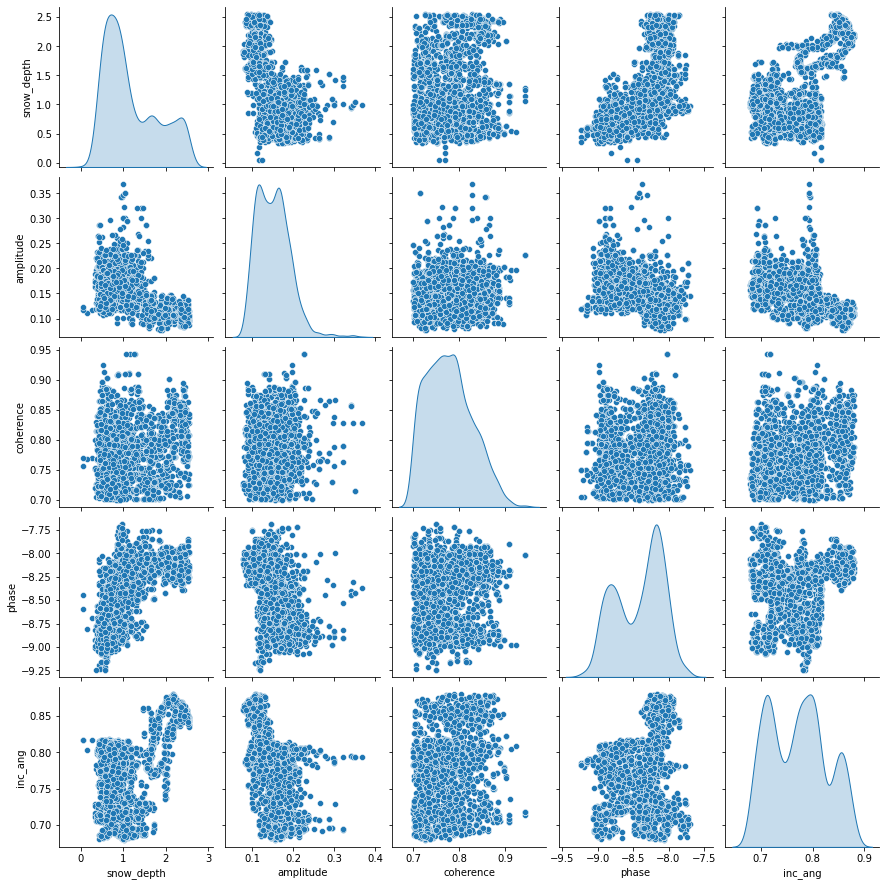

In [5]:
sns.pairplot(train_dataset[['snow_depth','amplitude', 'coherence', 'phase', 'inc_ang']], diag_kind='kde')

Each panel of the scatterplot matrix is a scatterplot for a pair of variables whose identities are given by the corresponding row and column labels. None of the features have a linear relationship with $\texttt{snow_depth}$. This may indicate that a linear model might not be the best option.

**Descriptive Statistics**

- count: the size of the training set
- mean: arithmetic mean
- std: sample standard deviation
- min: minimum value
- 25%: 25$^{th}$ percentile
- 50%: 50$^{th}$ percentile also called the median
- 75%: 75$^{th}$ percentile
- max: maximum value

In [6]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
amplitude,2400.0,0.151192,0.040073,0.077860,0.119580,0.148579,0.175531,0.368253
coherence,2400.0,0.778119,0.048796,0.700428,0.738597,0.773580,0.811030,0.942499
phase,2400.0,-8.419475,0.338714,-9.240785,-8.743792,-8.326929,-8.145543,-7.690262
inc_ang,2400.0,0.772514,0.054758,0.679981,0.719910,0.775250,0.809429,0.880183
snow_depth,2400.0,1.178734,0.629103,0.051438,0.667404,0.961838,1.652085,2.551194


### Normalization

The features and outcome are measured in diferent units and hence are on different scales. Machine Learning algorithms are very sensitive and important information can be lost if they are not on the same scale A simple way to address this is to project all the variables onto the same scale, in a process known as **Normalization**.

Normalization simply consists of transforming the variables such that all values are in the unit interval [0, 1]. With Normalization, if $X_j$ is one of the variables, and we have $n$ observations $X_{1j}, X_{2j}, \cdots, X_{nj}$, then the normalized version of $X_{ij}$ is given by

$$
\tilde{X}{ij} = \frac{X_{ij} - \min X_j}{\max X_j - \min X_j}
$$

In [7]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_dataset)
scaled_test = scaler.transform(test_dataset) ## fit_transform != transform. 
                                             ## transform uses the parameters of fit_transform

### Sepatare Features from Labels

Our last dtep for preparing the data for Machine Learning is to separate the features from the outcome.

In [8]:
train_X, train_y = scaled_train[:, :-1], scaled_train[:, -1]
test_X, test_y = scaled_test[:, :-1], scaled_test[:, -1]

## Why Estimate $f$?

We estimate $f$ for two main reasons;

1. Prediction: in this case, the features $X$ are available, but there is no explicit rule for obtaining the outcome $Y$.
2. Inference: in practice, we are sometimes interested in how changing the input $X$ effects $Y$. Inference can tell us which features are significantly associated with a paticular outcome and the nature of the relationship between $X$ and $Y$.
    

## How Do We Estimate $f$?

### Machine Learning Algorithms

Machine learning algorithms can be categorized based on different criteria. In this tutorial, our categorization will be based on the amount and type of supervision needed during the training process. Based on this criterion, there are four major categories; supervised learning, unsupervised learning, semisupervised learning, and reinforcement learning. We shall limit our definition to the first two;

* **Supervised Learning**: this refers to tasks where we have a specific outcome to predict. That is, every observation of the features has a corresponding outcome. An example of a supervised learning task is predicting snow depth based on some influencing features.
	 
* **Unsupervised Learning**: this refers to tasks where we have no outcome to predict.  Here, rather than predict an outcome, we seek to understand the relationship between the features or between the observations or to detect anomalous observations. Considering the example above, we assume the snow depth variable does not exist and we either understand the relationship between the features or between the observations based on the features.


It is worth noting that a variable can either be categorical or continuous. For now, let's focus on the nature of the outcome variable. In *Supervised Learning* parlance, if the outcome variable is categorical, we have a *classification* task and if continuous, we are in the presence of a *regression* task. Categorical implies that the variable is made of distinct categories (e.g. hair color: grey, blonde, black) and continuous implies that the variable is measured (e.g. snow depth). For the rest of this tutorial, we will focus on *Supervised Learning* tasks with a special concentration on regression tasks.


## Machine Learning Installation Guide

For this notebook to run successfully, you have to install the follwing packages;

1. TensorFlow
2. Keras

**Tensorflow**: it is an end-to-end open source platform for machine learning. It makes it easy to train and deploy machine learning models. TensorFlow was created at Google and supports many of their large-scale Machine Learning applications. Read more at [About TensorFlow](https://keras.io/about/)

**Keras:**  Keras is a deep learning Application Programming Interface (API) written in Python, running on top of the machine learning platform TensorFlow. It was developed with a focus on enabling fast experimentation. Read more at [About Keras](https://www.tensorflow.org/).

Other packages needed come pre-installed in Anaconda

The install the packages above, lunch the **Anaconda prompt** and type the following commands

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\texttt{C:\Users\Default> pip install tensorflow}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\texttt{C:\Users\Default> pip install keras}$

After installation, you will be able to continue with the tutorial. For this tutorial, both Tensorflow and Keras used are version 2.5


Most Machine Learning techniques can be characterised as either *parametric* or *non-parametric*. A common parametric method is Linear Regression while Neural Networks are a common non-parametric method.

## Linear Regression

Assume a functional form for $f$, e.g we may assume that $f$ is a linear function of $X$:

$$f(X) = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_k X_k$$

and the goal of ML is to estimate the parameters of the model $\beta_0, \beta_1, \cdots, \beta_k$. This is called Linear Regression.

The parametric approach simplifies the problem of estimating $f$ to a parameter estimation problem. The disadvantage is that we assume a particular shape of $f$ that may not match the true shape of $f$. The major advantage of using parametric approach that when inference is the goal we can understand how changing $X_1, X_2, \cdots, X_k$ effects $Y$


## Performance Evaluation

Each time we estimate the true outcome ($Y$) using a trained ML algorithm ($f(X)$), the discrepancy between the observed and predicted must be quantified. The question is, how do we quantify this discrepancy? This brings the notion of **loss function**. 

*Loss Function* $\mathcal{L} (\cdot,\cdot)$ is a bivariate function that quantifies the loss (error) we sustain from predicting $Y$ with $f(X)$. Put another way, **loss fuction** quantifies how close the prediction $f(X)$ is to the ground truth $Y$.

* Regression Loss Function

There exists quite a number of ways for which the loss of a regression problem may be quantified. We now illustrate two of them;

1. 

$$
\mathcal{L} (Y,f(X)) = (Y - f(X))^2
$$

This is popularly known as the *squared error loss* and it is simply the square of the difference between the observed and the predicted values. The loss is squared so that the function reaches its minimum (convex).

2.

$$
\mathcal{L} (Y,f(X)) = |Y - f(X)|
$$

Another way to quantify regression loss is by taking the absolute value of the difference between the observed ($Y$) and the predicted ($f(X)$) values. This is called the L1 loss.

It is worth noting that the *loss function* as defined above corresponds to a single observation. However, in practice, we want to quantify the loss over the entire dataset and this is where the notion of **empirical risk** comes in. Loss quantified over the entire dataset is called the *empirical risk*. Our goal in ML is to develop an algorithm such that the *empirical risk* is as minimum as possible. *Empirical risk* is also called the *cost function* or the *objective function* we want to minimize.

* Regression Empirical Risk

$$
\widehat{\mathcal{R}}_n(f) = \frac{1}{n}\sum_{i=1}^n{\mathcal{L}(Y_i, f(X_i))}
$$

The empirical risk corresponding to the squared error loss is called "mean squared error", while the empirical risk corresponding to the L1 loss is called "mean absolute error". Other Regression Loss functions can be found at [Keras: losses](https://keras.io/api/losses/)

## Modeling Setup

Load libraries:

In [9]:
import tensorflow as tf
from keras import models
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

In [10]:
### Check the version of Tensorflow and Keras

print("TensorFlow version ==>", tf.__version__)
import keras; print("Keras version ==>",keras.__version__)

TensorFlow version ==> 2.5.0
Keras version ==> 2.5.0


The machine learning algorithm uses a linear regression model to fit the features to the outcome. It will initialize different weights depending on the seed. We define a random seed so that we get same result each time we do the regression.

In [11]:
tf.random.set_seed(0) ## For reproducible results
linear_regression = models.Sequential() # Specify layers in their sequential order
# inputs are 4 dimensions (4 dimensions = 4 features)
# Dense = Fully Connected.  
linear_regression.add(layers.Dense(1, activation=None ,input_shape=(train_X.shape[1],)))
# Ouput layer has no activation with just 1 node

* **Compile**

In [12]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
linear_regression.compile(optimizer = opt, loss='mean_squared_error')

The mean squared error is minimized to find optimal parameters. A discussion of diffent optimization methods is provided in Appendix A.

* **Print Architecture**

In [13]:
print(linear_regression.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
None


Note since there are 4 features, we have 5 regression parameters.

* **Fit Model**

The regression parameters are formed with data in the training set. An epoch is when an entire batch of the training set has been used. The number of times we iterate over the dataset is known as the number of **epochs**.

In [14]:
history =linear_regression.fit(train_X, train_y, epochs=150, validation_split = 0.2)

Epoch 1/150
60/60 [==============================] - 8s 5ms/step - loss: 0.5058 - val_loss: 0.4932
Epoch 2/150
60/60 [==============================] - 0s 661us/step - loss: 0.4897 - val_loss: 0.4727
Epoch 3/150
60/60 [==============================] - 0s 645us/step - loss: 0.4746 - val_loss: 0.4530
Epoch 4/150
60/60 [==============================] - 0s 631us/step - loss: 0.4625 - val_loss: 0.4336
Epoch 5/150
60/60 [==============================] - 0s 646us/step - loss: 0.4320 - val_loss: 0.4152
Epoch 6/150
60/60 [==============================] - 0s 646us/step - loss: 0.4166 - val_loss: 0.3974
Epoch 7/150
60/60 [==============================] - 0s 631us/step - loss: 0.4021 - val_loss: 0.3801
Epoch 8/150
60/60 [==============================] - 0s 707us/step - loss: 0.3811 - val_loss: 0.3635
Epoch 9/150
60/60 [==============================] - 0s 630us/step - loss: 0.3703 - val_loss: 0.3474
Epoch 10/150
60/60 [==============================] - 0s 626us/step - loss: 0.3436 - val_loss

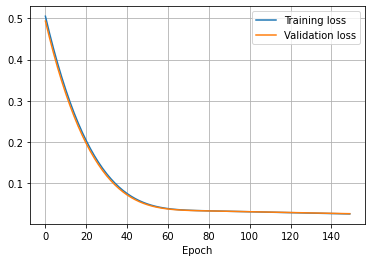

In [15]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

### Linear Regression Coefficient

Note that all coefficients are from the transformed data. Therefore, we need to take the inverse transform before quantifying our error.

In [16]:
linear_regression.get_weights()

[array([[-0.3102402 ],
        [-0.14108339],
        [ 0.4089547 ],
        [ 0.39944437]], dtype=float32),
 array([0.18064038], dtype=float32)]

**model**: $\texttt{snow_depth} = 0.18 - 0.31 \texttt{amplitude} - 0.14 \texttt{coherence} + 0.40\texttt{phase} + 0.40\texttt{inc_ang} $ 

## Neural Networks

Neural networks (NN) are a type of non-parametric method. Another non-parametric approach is Support Vector Machine (SVM) but we will not discuss that here. Non-parametric approaches do not assume any shape for $f$. Instead, the try to estimate $f$ that gets as close to the data points as possible. Neural networks are learning machines inspired by the functionality of biological neurons. They are not models of the brain, because there is no proven evidence that the brain operates the same way neural networks learn representations. However, some of the concepts were inspired by understanding the brain. Every NN consists of three distinct layers; 

1. Input layer 
2. Hidden layer(s) and 
3. Output layer. 

To understand the functioning of these layers, we begin by exploring the building blocks of neural networks; a single neuron or perceptron.

### A preceptron or Single Neuron

Each layer in a NN consists of small individual units called neurons (usually represented with a circle). A neuron receives inputs from other neurons, performs some mathematical operations, and then produces an output. Each neuron in the input layer represents a  feature. In essence, the number of neurons in the input layer equals the number of features. Each neuron in the input layer is connected to every neuron in the hidden layer. The number of neurons in the hidden layer is not fixed, it is problem dependent and it is often determined via cross-validation or validation set approach in practice. 

<img src="images/feedforward.png" alt="Drawing" style="width: 500px;"/>

The configuration of the hidden layer(s) controls the complexity of the network. A NN may contain more than one hidden layer. A NN with more than one hidden layer is called a **deep neural network** while that with a single hidden layer is a **shallow neural network**. The final layer of a neural network is called the output layer and it holds the predicted outcomes of observations passed into the input layer. Every inter-neuron connection has an associated weight, these weights are what the neural network learns during the training process. When connections between the layers do not form a loop, such networks are called **feedforward neural networks** and if otherwise, they are called **recurrent neural networks**. In this tutorial, we shall concentrate on the feed forward neural networks.



#### How the perceptron works

Consider a dataset $\mathcal{D}_n = \left\lbrace (\textbf{x}_1, y_1), (\textbf{x}_2, y_2), \cdots, (\textbf{x}_n, y_n) \right\rbrace$ where $\textbf{x}_i^\top \equiv ({x}_{i1}, {x}_{i2}, \cdots, {x}_{ik})$ denotes the $k$-dimensional vector of features, and $y_i$ represents the corresponding outcome. Given a set of input fed into the network through the input layer, the output of a neuron in the hidden layer is

$$
 f(\textbf{x}_i;\textbf{w}) = g(w_0 + \textbf{w}^\top \textbf{x}_i),
$$

where $\textbf{w} = (w_1, w_2, \cdots, w_k)^\top$ is a vector of weights and  $w_0$ is the bias term associated with the neuron. The weights can be thought of as the slopes in a linear regression and the bias as the intercept. The function $g(\cdot)$ is known as the activation function and it is  used to introduce non-linearity into the network.

<img src="images/perceptron.png" alt="Drawing" style="width: 400px;"/>

$\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$  A Perceptron

There exists a number of activation functions in practice, the commonly used ones are

1. Sigmoid or Logistic activation function $$g(z) = \frac{1}{1 + e^{-z}}.$$
2. Hyperbolic Tangent activation function $$g(z) = \tanh (z) = \frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}.$$
3. Rectified Linear Unit activation function $$g(z) = \max(0,z).$$

### Visualizing Activation Functions

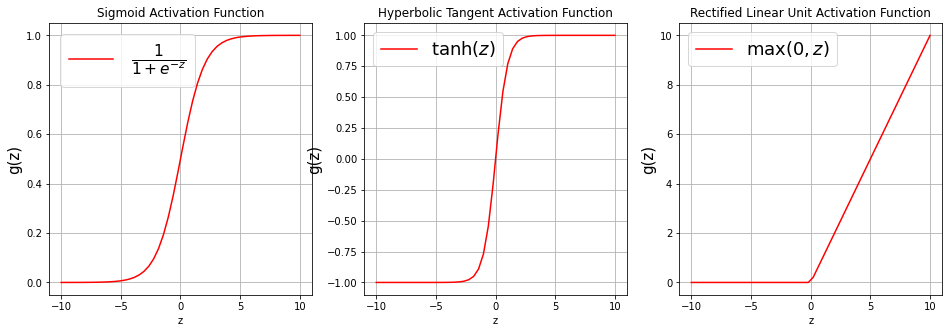

In [17]:
def Sigmoid(z):
    """
    A function that performs the sigmoid transformation
    
    Arguments:
    ---------
        -* z: array/list of numbers to activate
    
    Returns:
    --------
        -* logistic: the transformed/activated version of the array
    """
    
    logistic = 1/(1+ np.exp(-z))
    return logistic
    

def Tanh(z):
    """
    A function that performs the hyperbolic tangent transformation
    
    Arguments:
    ---------
        -* z: array/list of numbers to activate
    
    Returns:
    --------
        -* hyp: the transformed/activated version of the array
    """
    
    hyp = np.tanh(z)
    return hyp


def ReLu(z):
    """
    A function that performs the hyperbolic tangent transformation
    
    Arguments:
    ---------
        -* z: array/list of numbers to activate
    
    Returns:
    --------
        -* points: the transformed/activated version of the array
    """
    
    points = np.where(z < 0, 0, z)
    return points

z = np.linspace(-10,10)
fa = plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(z,Sigmoid(z),color="red", label=r'$\frac{1}{1 + e^{-z}}$')
plt.grid(True, which='both')
plt.xlabel('z')
plt.ylabel('g(z)', fontsize=15)
plt.title("Sigmoid Activation Function")
plt.legend(loc='best',fontsize = 22)


plt.subplot(1,3,2)
plt.plot(z,Tanh(z),color="red", label=r'$\tanh (z)$')
plt.grid(True, which='both')
plt.xlabel('z')
plt.ylabel('g(z)', fontsize=15)
plt.title("Hyperbolic Tangent Activation Function")
plt.legend(loc='best',fontsize = 18)

plt.subplot(1,3,3)
plt.plot(z,ReLu(z),color="red", label=r'$\max(0,z)$')
plt.grid(True, which='both')
plt.xlabel('z')
plt.ylabel('g(z)', fontsize=15)
plt.title("Rectified Linear Unit Activation Function")
plt.legend(loc='best', fontsize = 18)

### Families of Neural Networks

1. Feedforward Neural Networks: often used for structural data
2. Convolutional Neural Networks: the gold standard for image classification
3. Transfer Learning: reusing knowledge from previous tasks on new tasks
4. Recurrent Neural Networks: well suited for sequence data such as texts, time series, drawing generation
5. Encoder-Decoders: comminly used for but not limited to machine translation
6. Generative Adversarial Networks: usually used for 3D modelling for video games, animation, etc.
7. Graph Neural Networks: usually used to work with graph data.

### Feedforward Neural Network

* **Specify Architecture**

Here, we shall include three hidden layers with 1000, 512, and 256 neurons respectively. Layers added using the "$\texttt{network.add($\cdots$)}$" command.

In [18]:
tf.random.set_seed(1000)  ## For reproducible results
network = models.Sequential() # Specify layers in their sequential order
# inputs are 4 dimesions (4 dimensions = 4 features)
# Dense = Fully Connected.   
# First hidden layer has 1000 neurons with relu activations.
# Second hidden layer has 512 neurons with relu activations
# Third hidden layer has 256 neurons with Sigmoid activations
network.add(layers.Dense(1000, activation='relu' ,input_shape=(train_X.shape[1],)))
network.add(layers.Dense(512, activation='relu')) # sigmoid, tanh
network.add(layers.Dense(256, activation='sigmoid'))
# Ouput layer uses no activation with 1 ouput neurons
network.add(layers.Dense(1)) # Output layer

* **Compile**

The learning rate controls how the weights and bias are optimized. A discussion of the optimization procedure for Neural Networks can be found in Appendix B. If the learning rate is too small the training may get stuck, while if it is too big the trained model may be unreliable.

In [19]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
network.compile(optimizer = opt, loss='mean_squared_error')

* **Print Architecture**

In [20]:
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              5000      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 649,097
Trainable params: 649,097
Non-trainable params: 0
_________________________________________________________________


Number of weights connecting the input and the first hidden layer = (1000 $\times$ 4) + 1000(bias) = 5000 

* 4 = $\texttt{number of features}$
* 1000 = $\texttt{number of nodes in the first hidden layer}$

Number of weights connecting the first hidden layer and the second hidden layer = (1000 $\times$ 512) + 512(bias) = 512512 

* 512 = $\texttt{number of nodes in the second hidden layer}$
* 1000 = $\texttt{number of nodes in the first hidden layer}$

Number of weights connecting the second hidden layer and the third hidden layer = (512 $\times$ 256) + 256(bias) = 131328 

* 256 = $\texttt{number of nodes in the third hidden layer}$
* 512 = $\texttt{number of nodes in the second hidden layer}$

Number of weights connecting the third (last) hidden and the output layers = (256 $\times$ 1) + 1(bias) = 257 

* 256 = $\texttt{number of nodes in the third hidden layer}$
* 1 = $\texttt{number of nodes in the output layer}$

* **Fit Model**

In [21]:
history =network.fit(train_X, train_y, epochs=150, validation_split = 0.2)

Epoch 1/150
60/60 [==============================] - 1s 6ms/step - loss: 0.0976 - val_loss: 0.0299
Epoch 2/150
60/60 [==============================] - 0s 4ms/step - loss: 0.0261 - val_loss: 0.0199
Epoch 3/150
60/60 [==============================] - 0s 4ms/step - loss: 0.0210 - val_loss: 0.0173
Epoch 4/150
60/60 [==============================] - 0s 4ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 5/150
60/60 [==============================] - 0s 4ms/step - loss: 0.0158 - val_loss: 0.0145
Epoch 6/150
60/60 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 7/150
60/60 [==============================] - 0s 4ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 8/150
60/60 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 9/150
60/60 [==============================] - 0s 4ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 10/150
60/60 [==============================] - 0s 4ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 11/

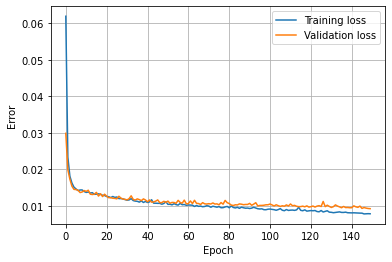

In [22]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

### Prediction

We have used Machine Learning to build two computer models $f$ with SnowEx data. Now we will use the computer models to estimate snow depth for a given set of features (phase, coherence, amplitude, incidence angle).

In [23]:
## Linear Regression

yhat_linReg = linear_regression.predict(test_X)
inv_yhat_linReg = np.concatenate((test_X, yhat_linReg), axis=1)
inv_yhat_linReg = scaler.inverse_transform(inv_yhat_linReg)
inv_yhat_linReg = inv_yhat_linReg[:,-1]

## DNN
yhat_dnn = network.predict(test_X) 
inv_yhat_dnn = np.concatenate((test_X, yhat_dnn), axis=1)
inv_yhat_dnn = scaler.inverse_transform(inv_yhat_dnn)
inv_yhat_dnn = inv_yhat_dnn[:,-1]

## True Snow Depth (Test Set)
inv_y = test_dataset["snow_depth"]


## Put Observed and Predicted (Linear Regression and DNN) in a Dataframe
prediction_df = pd.DataFrame({"Observed": inv_y,
                    "LR":inv_yhat_linReg, "DNN":inv_yhat_dnn})

### Check Performance

In [24]:
def metrics_print(test_data,test_predict):
    print('Test RMSE: ', round(np.sqrt(mean_squared_error(test_data, test_predict)), 2))
    print('Test R^2 : ', round((r2_score(test_data, test_predict)*100), 2) ,"%")
    print('Test MAPE: ', round(mean_absolute_percentage_error(test_data, test_predict)*100,2), '%')

In [25]:
print("##************** Linear Regression Results **************##")
metrics_print(prediction_df['Observed'], prediction_df['LR'])
print(" ")
print(" ")

print("##************** Deep Learning Results **************##")
metrics_print(prediction_df['Observed'], prediction_df['DNN'])
print(" ")
print(" ")

##************** Linear Regression Results **************##
Test RMSE:  0.43
Test R^2 :  54.87 %
Test MAPE:  38.3 %
 
 
##************** Deep Learning Results **************##
Test RMSE:  0.25
Test R^2 :  84.35 %
Test MAPE:  18.44 %
 
 


### Visualize Performance

Text(0.5, 1.0, 'Deep Neural Network')

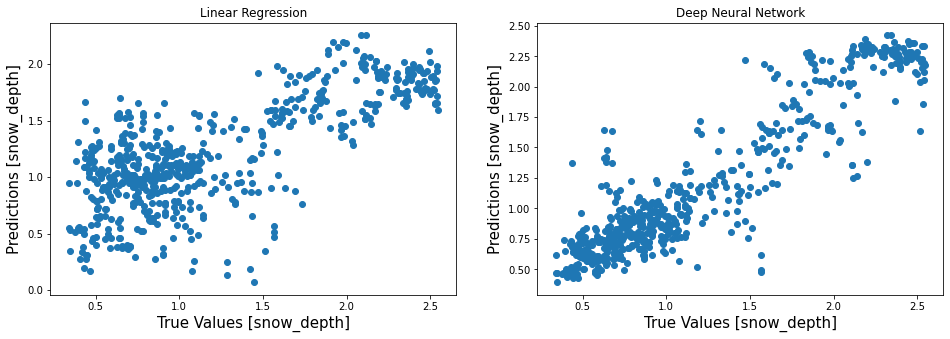

In [26]:
fa = plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.scatter(prediction_df['Observed'],prediction_df['LR'])
plt.xlabel('True Values [snow_depth]', fontsize=15)
plt.ylabel('Predictions [snow_depth]', fontsize=15)
plt.title("Linear Regression")


plt.subplot(1,2,2)
plt.scatter(prediction_df['Observed'],prediction_df['DNN'])
plt.xlabel('True Values [snow_depth]', fontsize=15)
plt.ylabel('Predictions [snow_depth]', fontsize=15)
plt.title("Deep Neural Network")


### Visualize Error

Text(0.5, 1.0, 'Deep Neural Network')

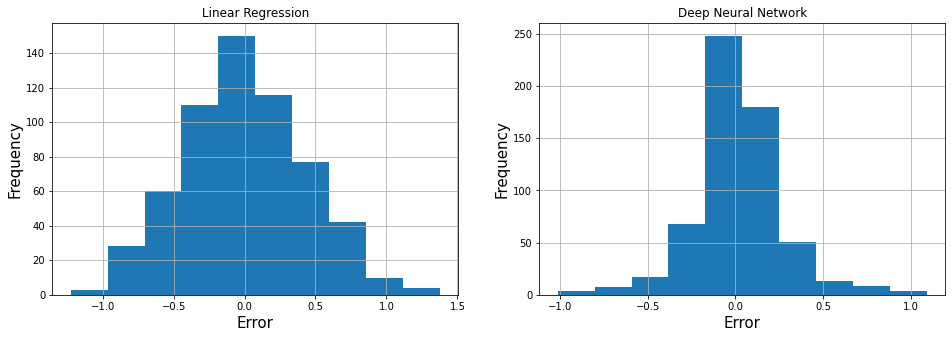

In [27]:
LR_error = prediction_df['Observed'] - prediction_df['LR']
DNN_error = prediction_df['Observed'] - prediction_df['DNN']

fa = plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
LR_error.hist()
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Linear Regression")

plt.subplot(1,2,2)
DNN_error.hist()
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Deep Neural Network")

### Save the Best Model

In [28]:
network.save('DNN')

## To load model, use;
model = keras.models.load_model('DNN')

INFO:tensorflow:Assets written to: DNN/assets


### Main Challenges of Machine Learning

1. Bad Data (insufficient training data, nonrepresentative training data, irrelevant features)
2. Bad Algorithm (overfitting the training the data, underfitting the training data)

### Improving your Deep Learning Model

Here are some ways to improve your deep neural network;

1. Regularization (early stopping, dropout, etc)
2. Hyperparameter Optimization

## Your Turn

Using same dataset, fit a deep neural network with four hidden layers. Set a random seed of 200 for reproducible results. The number of neuron in the hidden layers should be 512, 256, 128, and 64 respectively. Use the "sigmoid" activation for all hidden layers, optimize using the "mean_absolute_error", and set your number of epochs to 50. 

1. Plot the training and validation loss. COmpare to previous DNN model.
2. Use new DNN model to predict snow depth with the test data. Evaluate performance using RMSE, $R^2$, and MAPE. Compare to results from previous DNN model.
3. Plot predicted snow depth vs. the observed snow depth. Which DNN model do you think is most reliable?

## Reference

1. [Santiago on Twitter](https://twitter.com/svpino)
2. [A Taxonomy of Big Data for Optimal Predictive Machine Learning and Data Mining by Ernest Fokoue](https://arxiv.org/abs/1501.00604)
3. [An Introduction to Statistical Learning with Applications in R](https://link.springer.com/book/10.1007%2F978-1-4614-7138-7)
4. [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edition](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646)
5. [MIT 6.S191: Introduction to Deep Learning](https://www.youtube.com/channel/UCtslD4DGH6PKyG_1gFAX7sg)
6. [Intro to Deep Learning (ML Tech Talks)](https://www.youtube.com/watch?v=AhE8RhPGH1A&t=2685s)

## Appendix A

### Linear Regression Weights

Linear regression is a very simple supervised learning technique used for predicting a quantitative outcome variable. It is a parametric approach that lives up its name: it assumes a linear relationship between the outcome and the predictors. When only one predictor is involved, it is called $\texttt{Simple Linear Regression}$ and when more than one predictor is involved, it is called $\texttt{Multiple Linear Regression}$. For illustration purpose, the multiple linear regression will be used. 

Consider a dataset $\mathcal{D}_n = \left\lbrace (\textbf{x}_1, y_1), (\textbf{x}_2, y_2), \cdots, (\textbf{x}_n, y_n) \right\rbrace$ where $\textbf{x}_i^\top \equiv ({x}_{i1}, {x}_{i2}, \cdots, {x}_{ik})$ denotes the $k$-dimensional vector of the features, and $y_i$ represents the corresponding outcome. In our case, $y_i$ is continuous. Mathematically, the predicted value ($\hat{y}$) from the linear regression is given as;

$$\hat{y} = w_0 + \textbf{w}^\top \textbf{x} = w_0 + w_1x_1 + w_2x_2 + \cdots + w_kx_k$$

where $\textbf{w} = (w_1, w_2, \cdots, w_k)^\top \in \mathbb{R}^k$ is a vector of weights and  $w_0  \in \mathbb{R}$ is the bias/intercept term. The weights could be thought of as how each feature affects the prediction. If a feature receives a positive weight, then increasing the value of that feature
increases the value of our prediction and vise versa.

### Training a Linear Regression (Estimating the Optimal Weights)

Just as mentioned above, there are differnt ways to quantify loss of a regression problem. In this tutorial, we shall limit our discussion to the squared error loss. For linear regression using the squared error loss, the loss function is written as

$$\mathcal{L} (y, \hat{y}) = (y - \hat{y})^2$$

The corresponding empirical risk is given as


$$
\widehat{\mathcal{R}}_n(\textbf{w}) = \frac{1}{n^{(tr)}} \sum_{i = 1}^{n^{(tr)}}(y_i - \hat{y}_i)^2
$$

In essence, we want to find a set of weights such that the empirical risk is minimized. The full empirical risk minimization for linear regression can be written as:

$$
\textbf{w}^{\star} = \underset{\textbf{w}}{{\tt argmin}}\  \widehat{\mathcal{R}}_n(\textbf{w})
$$

The superscript ($tr$) indicates that all optimization is performed on the train set only.

#### Optimizing the Empirical Risk

The empirical risk as written above can be optimized in two ways;

1. Using the Ordinary Least Squares approach
2. Using Gradient Descent.

**Ordinary Least Squares (OLS)**: OLS is an unconstrained optimization technique which minimizes the sum of squared residuals (squared error loss). The OLS approach provides a closed-form (formula) solution to the empirical risk minimization problem. In this tutorial, we shall state the closed form solution without proof. The closed form solution to the empirical risk minimization problem is written as;

$$
\textbf{w}^{\star} = (\textbf{X}_{tr}^\top \textbf{X})^{-1} \textbf{X}_{tr}^\top \textbf{y}_{tr}
$$

Where $\textbf{X}_{tr}$ is the training data matrix and $\textbf{y}_{tr}$ the vector of training dependent variable.

**Gradient Decent**: the gradient descent algorithm is as follows:

1. Initialize weights and biases with random numbers.
2. Loop until convergence:
    1. Compute the gradient; $\frac{\partial \widehat{\mathcal{R}}_n(\textbf{w})}{\partial \textbf{w}}$
    2. Updated weights; $\textbf{w} \leftarrow  \textbf{w} - \eta  \frac{\partial \widehat{\mathcal{R}}_n(\textbf{w})}{\partial \textbf{w}}$
3. Return the weights

This is repeated for the bias and every single weight. The $\eta$ in step 2(B) of the gradient descent algorithm is called the learning rate. It is a measure of how fast we descend the hill (since we are moving from large to small errors). Large learning rates may cause divergence and very small learning rates may take too many iterations before convergence.

## Appendix B

### Neural Network Weights

Building up a NN with at least one hidden layer known as  multi layer perceptron (MLP) requires only repeating the  mathematical operation illustrated for the perceptron for every neuron in the hidden layer(s). Consider the feedforward NN in the above figure, each neuron in the hidden layer does the follow computation:

$$z_j = w_{0,j}^{(1)} + \textbf{w}_j^{\top(1)}\textbf{x}_i$$

The final output (predicted value) is;

$$\hat{y}_i =h(w_{0,j}^{(2)} + \textbf{w}_j^{\top(2)}g(\textbf{z}_i))$$

where $\textbf{w}_j^{(1)}$ is the vector of weights connecting the input layer to the $j$th neuron of the hidden layer, $\textbf{w}_j^{(2)}$ is the vector of weights connecting the $j$th neuron in the hidden layer to the output neuron, and $h(\cdot)$ is the activation function applied to the output layer (if any).

### Training a Neural Network (Finding Optimal Weights for Prediction)

A neural network using gradient descent approach as spelt out above. The only the difference is how the gradient ($\frac{\partial \widehat{\mathcal{R}}_n(\textbf{w})}{\partial \textbf{w}}$) in step 2A. is performed. In neural networks, $\frac{\partial \widehat{\mathcal{R}}_n(\textbf{w})}{\partial \textbf{w}}$ is performed using the Backpropagation approach. The details of backpropagation is beyond the scope of this tutorial.
